# Infer ***cellmask*** from a composite image -  2️⃣ 

--------------

## OVERVIEW
In this notebook, we will continue segmenting the different cell regions - the nucleus, cell, and cytoplasm - since they will be necessary for determining which organelle are in which cell. This is integral to our single cell analysis approach.

This notebook goes through the workflow steps to segment the ***cell*** from a composite image made from a combination of fluorescent organelle marker.

> WARNING: 🚨🚨🚨🚨
>> Because we do NOT have a direct cell membrane or cell-fill signal, this segmentation is difficult and potentially problematic. The cell mask will be used to determine the area of each single in our single cell analysis.



## OBJECTIVE: 
### ✅ Infer sub-cellular component #2: ***cellmask***
Segment the cell area -- the ***cellmask*** -- from a composite image of multiple organelle markers combined. This method is used in the case where there is no cell fill/membrane marker.

In this example, there are multiple cells per field of view, but some of the cells do not contain all of the fluorescent markers (due to the transfection protocol used). Therefore, we will use a single cell selection process to identify the cell with the highest total fluorescence after all markers are combined. This assumption could lead to the selection of the "wrong" cell, but in pratice it has worked reasonably well. *In the future, more sophisticated quality control methods could be implemented to select cells with all of the labels.*

The cellmask will be necessary for determining the area of individual cells in our single cell analysis approach.

> ***Biological relevance:*** 
> The combination of organelle markers used to create the composite image for the cellmask segmentation depends on the organelle labeles used and the cell type. In this example, the current selection includes the lysosomes, ER, and Golgi (e.g., Ch = 1, 3, 5) which have some intracellular background fluorescence - likely from off target marker localization. The lipid droplet channel (e.g., `ch = 6`) could also be included to produce a more unbiased selection of the entire cellmask as it binds to all cellular membranes to a small extent. However, the drawback of this is that it is present in every cell which makes downstream cell selection of a single cell more challenging. 
>
> *It is important to consider specifics of your system as the cell type and labeling method may differ from the example above.*



## IMPORTS

In [24]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Union, Tuple, List

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling

from skimage import filters
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                     read_ome_image,
                                     import_inferred_organelle,
                                     export_inferred_organelle,
                                     list_image_files)

                                             
from infer_subc.core.img import *
from infer_subc.organelles import (get_nuclei, 
                                   non_linear_cellmask_transform,
                                   choose_max_label_cellmask_union_nucleus)
from infer_subc.constants import (TEST_IMG_N,
                                  NUC_CH ,
                                  LYSO_CH ,
                                  MITO_CH ,
                                  GOLGI_CH ,
                                  PEROX_CH ,
                                  ER_CH ,
                                  LD_CH ,
                                  RESIDUAL_CH) 

LD_CH = 0
NUC_CH = 1
LYSO_CH = 2
MITO_CH = 3
GOLGI_CH = 4
PEROX_CH = 5
ER_CH = 6
PM_CH = 7
RESIDUAL_CH = 8


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get and load Image for processing

In [25]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [26]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

----------
##  infer ***cellmask***

### summary of steps

➡️ INPUT (extract)
- segmented nuclei object (from [01_infer_nuclei](./02_infer_cellmask_from-composite.ipynb))
- create composite image from multiple organelle channels

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)
- log transform image
- apply scharr edge detection filter 
- combine log imge + scharr edge filtered intensity

CORE PROCESSING
- apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

POST-PROCESSING
  - fill holes (hole size = user input)
  - remove small objects (object size = user input)

OUTPUT ➡️ 
  - label unique cell objects based on watershed seeded from the nuclei objects
  - select the single cell with the highest combined fluorescence 
  - save single ***cellmask*** (cell, CM) at unsigned integer 8-bit tif files


> ***Note:*** this pipeline will eventually include a selection step to identify the cellmask that are properly labeled with all fluorescent markers. This could be one single cell per image, or more if applicable data is available.


## GET nuclei segmentation output

In [27]:
# Import nuclei segmentation from output folder, or 
# run nuclei segmentation with hard coded segmentation settings (not ideal for most scenarios)
nuclei_labels = get_nuclei(img_data, meta_dict, out_data_path)

loaded  inferred 3D `nuclei`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out 


In [28]:
# check the the image was correctly saved as uint16
nuclei_labels.dtype

dtype('uint16')

## EXTRACTION prototype

In [29]:
###################
# INPUT
###################
# add channels together with different weights
struct_img_raw = (3. * img_data[GOLGI_CH].copy().astype(np.double) +
                  3. * img_data[PEROX_CH].copy().astype(np.double) + 
                  2. * img_data[ER_CH].copy().astype(np.double))

In [30]:
# Creating a function to create composite image:
weights =  [0,0,0,0,3,3,2,0]
struct_img_raw2 = weighted_aggregate(img_data, *weights)

# use splat so we can also break out the arguments for our napari widget later
struct_img_raw3 = weighted_aggregate(img_data, 0,0,0,0,3,3,2,0)


# Comfirming the results are the same:
struct_img_raw[0,0:10,0], struct_img_raw2[0,0:10,0], struct_img_raw3[0,0:10,0]

(array([906., 307., 688.,  27., 871., 141., 351., 447., 314., 385.]),
 array([906., 307., 688.,  27., 871., 141., 351., 447., 314., 385.]),
 array([906., 307., 688.,  27., 871., 141., 351., 447., 314., 385.]))

## PRE-PROCESSING prototype


In [31]:
###################
# PRE_PROCESSING
###################
med_filter_size = 10
gaussian_smoothing_sigma = 1.34

structure_img_smooth = scale_and_smooth(struct_img_raw2,
                                        median_size = med_filter_size, 
                                        gauss_sigma = gaussian_smoothing_sigma)

In [32]:
# log scale the image, apply the scharr edge detection filter to logged image, add the two images together
composite_cellmask = non_linear_cellmask_transform(structure_img_smooth)

## CORE PROCESSING prototype

In [33]:
###################
# CORE_PROCESSING
###################
# threshold the composite image after log/edge detection using the MO filter function from aicssegmentation - this applies a global threshold, then a local threshold to produce a semantic segmentation
thresh_method = 'med'
cutoff_size =  150
thresh_adj = 0.3

bw = masked_object_thresh(composite_cellmask, 
                          global_method=thresh_method, 
                          cutoff_size=cutoff_size, 
                          local_adjust=thresh_adj)

## POST-PROCESSING prototype

In [34]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 50

small_object_width = 45

# removed_holes = hole_filling_linear_size(li_thresholded, 
#                                          hole_min=hole_min_width, 
#                                          hole_max=hole_max_width)
# 
# cleaned_img = size_filter_linear_size(removed_holes,
#                                       min_size=small_object_width)

cleaned_img2 = fill_and_filter_linear_size(bw, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size= small_object_width)

## POST POST-PROCESSING prototype

In [35]:
###################
# POST- POST_PROCESSING
###################
# apply a watershed to the inverted image using the nuclei as a seed for each cell
watershed_method = '3D'
cellmask_labels = masked_inverted_watershed(structure_img_smooth, 
                                            nuclei_labels, 
                                            cleaned_img2,
                                            method=watershed_method)

# find the cell with the highest total fluorescence after combining all channels together
keep_label = get_max_label(composite_cellmask, 
                           cellmask_labels)


# combine the above and find the nucleus associated to the highest fluorescence cell
cellmask_out = choose_max_label_cellmask_union_nucleus(structure_img_smooth,
                                                       cleaned_img2, 
                                                       nuclei_labels,
                                                       watershed_method=watershed_method)

cellmask = label_bool_as_uint16(cellmask_out)

In [25]:
cellmask.dtype

dtype('uint16')

## LABELING prototype

No labeling steps needed for this workflow.

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [36]:
viewer = napari.view_image(cleaned_img2, 
                           scale=scale)

12-Jan-24 09:31:37 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1920x1208+12+46 (frame: 1942x1264+1+1) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1920x1050+12+46 (frame: 1942x1106+1+1) margins: 11, 45, 11, 11 minimum size: 385x491 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=792,1038 maxtrack=0,0)


In [37]:
viewer.add_labels(
    cellmask, 
    scale=scale)

12-Jan-24 09:31:38 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1920x1208+0+34 (frame: 1942x1264-11-11) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1920x986+0+34 (frame: 1942x1042-11-11) margins: 11, 45, 11, 11 minimum size: 538x604 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=1098,1264 maxtrack=0,0)


<Labels layer 'cellmask' at 0x1e7a81d0700>

## SAVE inferred nuclei to .tif file

Based on the _prototyping_ above define the function to infer nuclei.  


In [38]:
out_file_n = export_inferred_organelle(cellmask, "cell", meta_dict, out_data_path)

saved file: 11252023_MSi08L_iPSCs_undiff_BR1_N20_Unmixing-cell


----------
## DEFINE `infer_cellmask_fromcomposite` function

Based on the _prototyping_ above define the function to infer nuclei. 

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [39]:
##########################
# 1. infer_cellmask_fromaggr
##########################
def _infer_cellmask_fromcomposite(in_img: np.ndarray,
                                  weights: list[int],
                                  nuclei_labels: np.ndarray,
                                  median_sz: int,
                                  gauss_sig: float,
                                  mo_method: str,
                                  mo_adjust: float,
                                  mo_cutoff_size: int,
                                  min_hole_w: int,
                                  max_hole_w: int,
                                  small_obj_w: int,
                                  watershed_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimu object size cutoff for cellmask signal post-processing
    watershed_method:
        determines if the watershed should be run 'sice-by-slice' or in '3D' 

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask

    """
    ###################
    # EXTRACT
    ###################
    struct_img = weighted_aggregate(in_img, *weights)

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = scale_and_smooth(struct_img,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)
    

    struct_img_non_lin = non_linear_cellmask_transform(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                      global_method=mo_method, 
                                      cutoff_size=mo_cutoff_size, 
                                      local_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size= small_obj_w)

    ###################
    # POST- POST_PROCESSING
    ###################
    cellmask_out = choose_max_label_cellmask_union_nucleus(struct_img, 
                                                           struct_obj, 
                                                           nuclei_labels, 
                                                           watershed_method=watershed_method) 

    return label_bool_as_uint16(cellmask_out)

## DEFINE `_fixed_infer_cellmask_fromcomposite` function

Based on the _prototyping_ above define the function to infer cellmask. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

In [40]:
##########################
# 1. fixed_infer_cellmask_fromaggr
##########################
def _fixed_infer_cellmask_fromcomposite(in_img: np.ndarray, nuclei_labels: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_labels: 
        a 3d image containing the inferred nuclei

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask
    """
    

    ###################
    # PARAMETERS
    ###################   
    weights = [0,0,0,3,3,2]
    median_sz = 10
    gauss_sig = 1.34
    mo_method = "med"
    mo_adjust = 0.3
    mo_cutoff_size = 150
    hole_min_width = 0
    hole_max_width = 50
    small_obj_w = 45
    watershed_method = '3D'

    cellmask_out = _infer_cellmask_fromcomposite(in_img,
                                                weights,
                                                nuclei_labels,
                                                median_sz,
                                                gauss_sig,
                                                mo_method,
                                                mo_adjust,
                                                mo_cutoff_size,
                                                hole_min_width,
                                                hole_max_width,
                                                small_obj_w,
                                                watershed_method) 

    return cellmask_out

## TEST `_infer_cellmask_fromcomposite`  function defined above

In [41]:
_CM_object =  _fixed_infer_cellmask_fromcomposite(img_data, nuclei_labels) 

_CM_object.dtype

dtype('uint16')

In [19]:
np.all(cellmask == _CM_object)

False

--------------------------

# TEST `infer_cellmask_fromcomposite` exported functions


In [42]:
from infer_subc.organelles import fixed_infer_cellmask_fromcomposite

cellmask_mask =  fixed_infer_cellmask_fromcomposite(img_data, nuclei_labels) 

In [21]:
np.all(cellmask_out == cellmask_mask)

False

## Visualize  2


In [43]:
viewer.add_labels(
    cellmask_mask,
    scale=scale)

<Labels layer 'cellmask_mask' at 0x1e7468d1300>

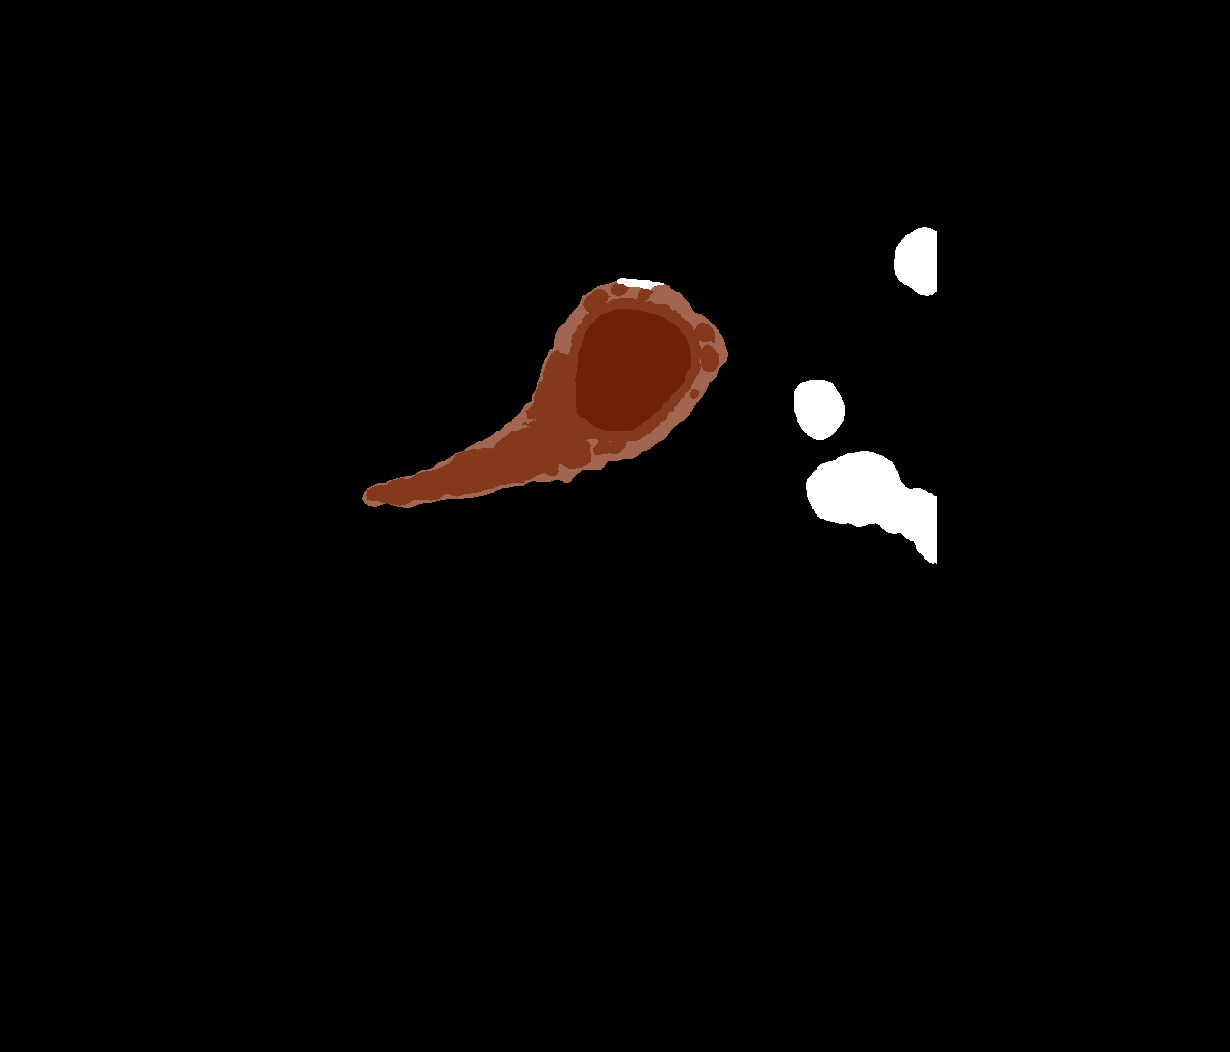

11-Jan-24 16:44:08 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1920x1212+0+34 (frame: 1942x1268-11-11) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1920x986+0+34 (frame: 1942x1042-11-11) margins: 11, 45, 11, 11 minimum size: 499x606 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=1020,1268 maxtrack=0,0)


In [37]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [25]:
viewer.close()

-------------
## SUMMARY

The above details how the nuclei object is inferred.  

### NEXT: INFER CYTOPLASM

proceed to [03_infer_cytoplasm.ipynb](./03_infer_cytoplasm.ipynb)
